In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


Extracting data for class: Normal
Extracting data for class: Weaponized
Extracting data for class: Violence
Saved feature files successfully


<ipython-input-6-b53e01aa6b25>:72: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.3724 - loss: 1.1142 - val_accuracy: 0.5257 - val_loss: 1.0219 - learning_rate: 0.0100
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.4986 - loss: 1.0106 - val_accuracy: 0.6449 - val_loss: 0.8017 - learning_rate: 0.0100
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.6520 - loss: 0.8139 - val_accuracy: 0.7897 - val_loss: 0.5266 - learning_rate: 0.0100
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7323 - loss: 0.6303 - val_accuracy: 0.8224 - val_loss: 0.4696 - learning_rate: 0.0100
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8271 - loss: 0.4785 - val_accuracy: 0.8505 - val_loss: 0.4085 - learning_rate: 0.0100
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8540 - loss: 0.3861 - val_accuracy: 0.8715 - val_loss: 0.3625 - learning_rate: 0.0100
Epoch 7/20
214/214 ━━━━━━━━━━━━━━

Accuracy Score: 0.9738317757009346
Model saved as Own_dataset_mobi_BiGRU.h5


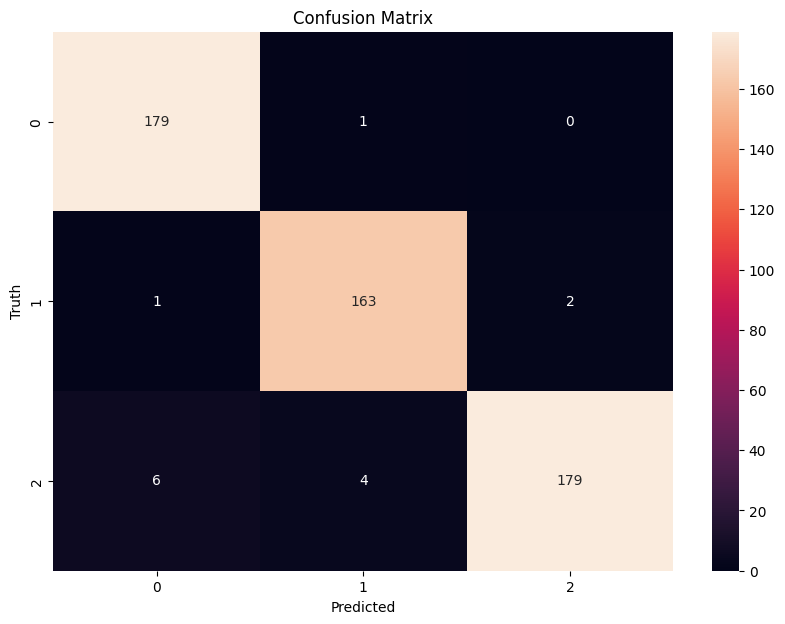


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       180
           1       0.97      0.98      0.98       166
           2       0.99      0.95      0.97       189

    accuracy                           0.97       535
   macro avg       0.97      0.97      0.97       535
weighted avg       0.97      0.97      0.97       535



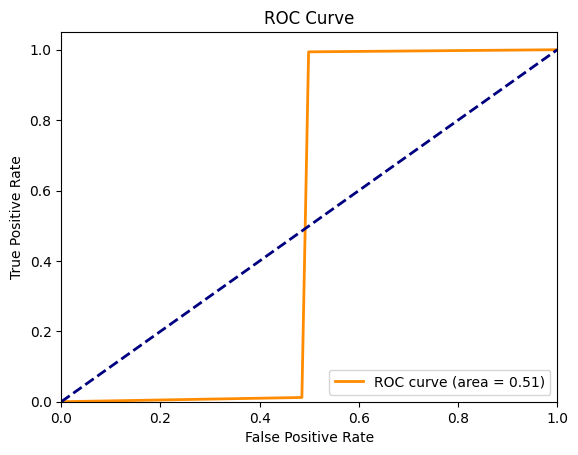

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Dropout, Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["Normal", "Weaponized", "Violence"]
video_dir = "/content/drive/MyDrive/Colab Notebooks/archive/SCVD_converted_sec_split/Train/"

# Frame extraction function
def frame_extraction(video_path):
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    frame_list = []
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, skip_frames_window * frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frame_list.append(normalized_frame)
    video_reader.release()
    return frame_list

# Dataset creation function
def create_dataset():
    features, labels, video_file_paths = [], [], []
    for class_index, class_name in enumerate(CLASSES_LIST):
        class_path = os.path.join(video_dir, class_name)
        print(f"Extracting data for class: {class_name}")
        for file_name in os.listdir(class_path):
            video_file_path = os.path.join(class_path, file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    features, labels = np.asarray(features), np.asarray(labels)
    return features, labels, video_file_paths

# Ensure the Features directory exists
os.makedirs("Features", exist_ok=True)

# Load and save features
features, labels, video_file_paths = create_dataset()
np.save("Features/features_Own.npy", features)
np.save("Features/labels_Own.npy", labels)
np.save("Features/video_file_paths_Own.npy", video_file_paths)

print("Saved feature files successfully")
# Load saved features
features, labels = np.load("Features/features_Own.npy"), np.load("Features/labels_Own.npy")
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2, random_state=42)

# Model creation function
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    mobilenet.trainable = True
    for layer in mobilenet.layers[:-40]:
        layer.trainable = False
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    # Replacing LSTM with BiGRU
    gru_fw = GRU(units=32)
    gru_bw = GRU(units=32, go_backwards=True)
    model.add(Bidirectional(gru_fw, backward_layer=gru_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    return model

# Compile and train the model
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

history = model.fit(features_train, labels_train, epochs=20, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
model_evaluation_history = model.evaluate(features_test, labels_test)
predictions = model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_test, axis=1)
acc_score = accuracy_score(predicted_labels, true_labels)
print(f'Accuracy Score: {acc_score}')

# Save the model
model.save("Own_dataset_mobi_BiGRU.h5")
print("Model saved as Own_dataset_mobi_BiGRU.h5")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["Normal", "Weaponized", "Violence"]
video_dir = "/content/drive/MyDrive/Colab Notebooks/archive/SCVD_converted_sec_split/Test/"

# Frame extraction function (same as before)
def frame_extraction(video_path):
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    frame_list = []
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, skip_frames_window * frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frame_list.append(normalized_frame)
    video_reader.release()
    return frame_list

# Function to predict videos in a given class folder
def predict_videos_in_folder(model, video_folder):
    print(f"Predicting videos in class folder: {video_folder}")
    for video_name in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_name)
        frames = frame_extraction(video_path)
        if len(frames) == SEQUENCE_LENGTH:
            frames = np.expand_dims(frames, axis=0)  # Adding batch dimension
            prediction = model.predict(frames)
            predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index
            predicted_label = CLASSES_LIST[predicted_class]  # Convert index to class label
            print(f"Video: {video_name} | Predicted Class: {predicted_label}")

# Load the trained BiGRU model
model = load_model("Own_dataset_mobi_BiGRU.h5")

# Predict for each folder (Normal, Weaponized, Violence)
for class_name in CLASSES_LIST:
    class_folder = os.path.join(video_dir, class_name)
    predict_videos_in_folder(model, class_folder)


Predicting videos in class folder: /content/drive/MyDrive/Colab Notebooks/archive/SCVD_converted_sec_split/Test/Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Video: Normal-Test009.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Video: Normal-Test005.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Video: Normal-Test008.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Video: Normal-Test003.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Video: Normal-Test004.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Video: Normal-Test007.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Video: Normal-Test006.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Video: Normal-Test002.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Video: Normal-Test001.avi | Predicted Class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Video: Normal-Test048.avi | Predi

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Constants for frame extraction
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16
CLASSES_LIST = ["Normal", "Weaponized", "Violence"]

# Load the trained model
model = load_model("Own_dataset_mobi_BiGRU.h5")

# Frame extraction function for a single video
def extract_frames_from_video(video_path):
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = video_reader.get(cv2.CAP_PROP_FRAME_COUNT)
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    frames = []

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, skip_frames_window * frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames.append(normalized_frame)

    video_reader.release()
    return np.array(frames)

# Prediction function for a single video
def predict_video_class(video_path):
    frames = extract_frames_from_video(video_path)
    if len(frames) < SEQUENCE_LENGTH:
        print("Not enough frames for prediction.")
        return None

    # Reshape to add batch dimension for prediction
    frames = np.expand_dims(frames, axis=0)
    predictions = model.predict(frames)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = CLASSES_LIST[predicted_class_index]
    return predicted_class_label

# User input for video path
video_path = input("Enter the path to the video file: ")

# Check if the video file exists and predict
if os.path.exists(video_path) and video_path.endswith(('.mp4', '.avi', '.mov')):
    print(f"\nPredicting for video: {video_path}")
    predicted_label = predict_video_class(video_path)
    if predicted_label:
        print(f"Predicted Class: {predicted_label}")
else:
    print("Invalid file path or file type. Please ensure the file exists and is a video format (mp4, avi, mov).")


Enter the path to the video file: /content/drive/MyDrive/Colab Notebooks/test_video.mp4

Predicting for video: /content/drive/MyDrive/Colab Notebooks/test_video.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Predicted Class: Violence


In [ ]:
/content/drive/MyDrive/Colab Notebooks/archive/SCVD_converted_sec_split/Test/Weaponized/Weaponized-Test003.avi
